## 500mm 75-87eV <a class="anchor" id="section-2"></a>

Fitted parameters:
t0 = 14.679703064376211 ns
E0 = 64.81743717192396 eV
s = 417.720710193286 mm


,"Energy, eV","t, ns","dt, ns","dt/t, %","dE/E, %","dE, eV","Sigma, ns"
0,87,164.22454,1.818828,1.107525,2.215050,0.963547,4.224517
1,85,171.31866,1.611608,0.940708,1.881415,0.799602,0.321183
2,83,179.95498,2.257331,1.254386,2.508773,1.041141,1.538545
3,81,189.82506,2.357126,1.241736,2.483472,1.005806,0.617455
4,79,201.54578,2.386333,1.184015,2.368030,0.935372,0.753905
5,77,216.35090,2.931505,1.354977,2.709954,1.043332,0.918412
6,75,235.47418,4.680902,1.987862,3.975724,1.490896,1.032345


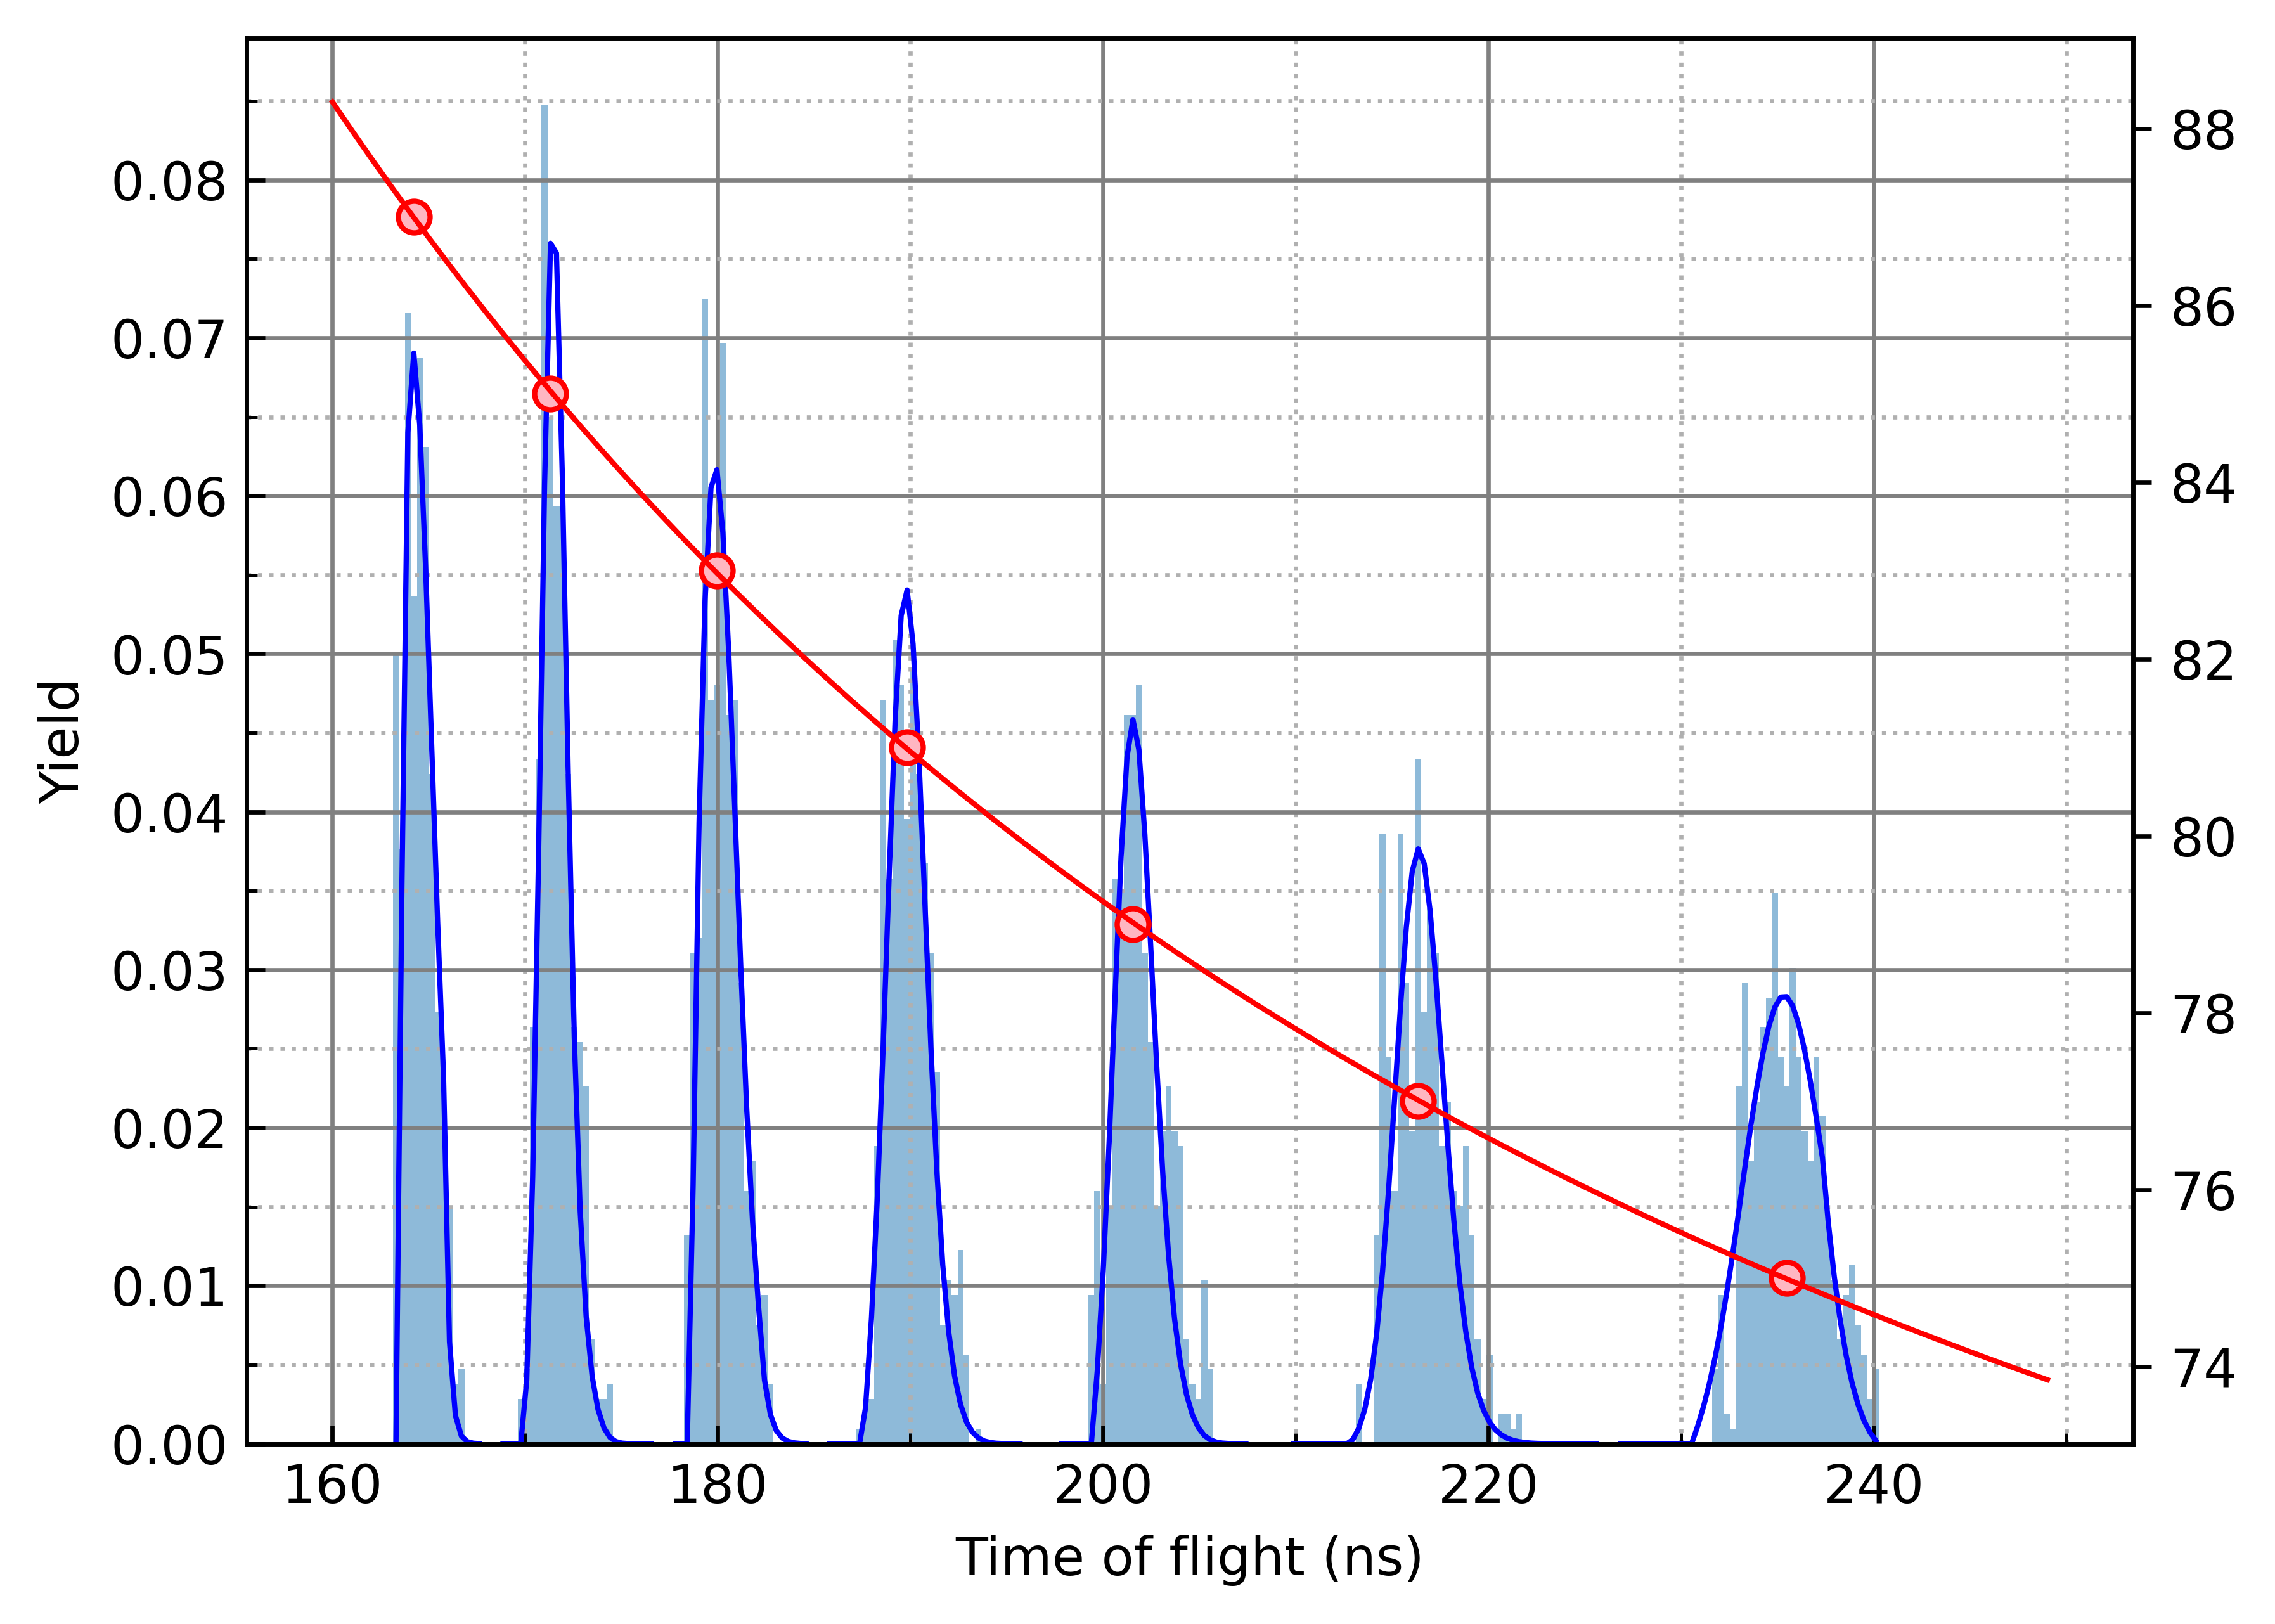

In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import *

fig, ax = plt.subplots(dpi=600)

x_start=160
x_end = 250
x_interval = 20
y_start = 0
y_end = 0.09
y_interval = 0.01
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=False)

data = read_file('./data/6k_ret.txt', delimeter=None)[0]
y, x, _ = plt.hist(data, 250, alpha=0.5, density=True)
x = (x[1:] + x[:-1])/2

times, sigmas, widths = [], [], []
energies = [87, 85, 83, 81, 79, 77, 75]
straight_times = [164.44, 171.11, 179.83, 189.41, 201.38, 215.92, 234.58]

bins = [(162, 168), (169, 177), (178, 185), (186, 196), (198, 208), (210, 226), (227, 242)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax,
                                    (straight_times[i], 1, 0, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

xr = np.arange(x_start, x_end, 1)
params, _ = curve_fit(time_to_energy, times, energies, (0, 0, 1117))
print(f"Fitted parameters:\nt0 = {params[0]*1e9} ns\nE0 = {params[1]} eV\ns = {params[2]} mm")

ax2 = ax.twinx()
ax2.scatter(times, energies, facecolors='#FFB6C1', edgecolors='r')
ax2.plot(xr, time_to_energy(xr, *params), lw=1, c='red')

d = {
    "Energy, eV": energies[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
df

## 1000mm 75-87eV <a class="anchor" id="section-2"></a>

Fitted parameters:
t0 = -45.49337996571165 ns
E0 = 62.00667592851092 eV
s = 1155.487734415645 mm


,"Energy, eV","t, ns","dt, ns","dt/t, %","dE/E, %","dE, eV","Sigma, ns"
0,87,344.13820,2.336111,0.678829,1.357658,0.590581,1.877315
1,85,360.87020,4.051337,1.122658,2.245315,0.954259,2.727530
2,83,379.61004,6.051373,1.594102,3.188205,1.323105,17.320978
3,81,401.02700,2.006775,0.500409,1.000818,0.405331,1.178398
4,79,427.79820,3.406557,0.796300,1.592600,0.629077,2.438079
5,77,457.24652,6.945763,1.519041,3.038083,1.169662,199322.626412


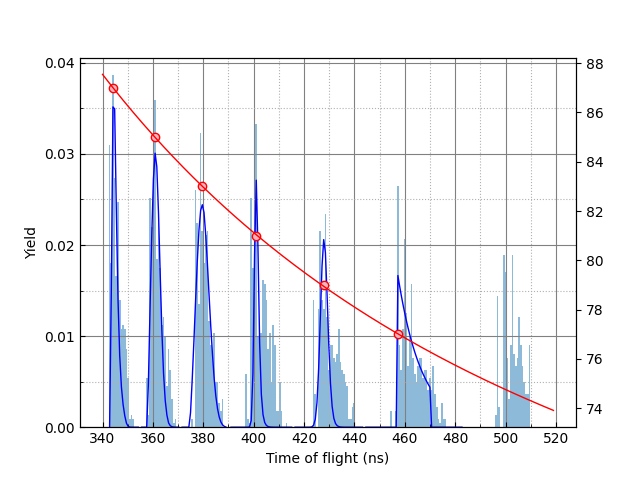

In [35]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import *

fig, ax = plt.subplots()

x_start=340
x_end = 520
x_interval = 20
y_start = 0
y_end = 0.09
y_interval = 0.01
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=False)

data = read_file('./data/6k_ret_1m.txt', delimeter=None)[0]
y, x, _ = plt.hist(data, 250, alpha=0.5, density=True)
x = (x[1:] + x[:-1])/2

times, sigmas, widths = [], [], []
energies = [87, 85, 83, 81, 79, 77]
straight_times = [343.8, 361.2, 378.3,  400.9, 427.3, 458.1] 

bins = [(340, 355), (356, 371), (372, 390), (391, 416), (417, 444), (445, 484)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax,
                                    (straight_times[i], 1, 0, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

xr = np.arange(x_start, x_end, 1)
params, _ = curve_fit(time_to_energy, times, energies, (0, 0, 1117))
print(f"Fitted parameters:\nt0 = {params[0]*1e9} ns\nE0 = {params[1]} eV\ns = {params[2]} mm")

ax2 = ax.twinx()
ax2.scatter(times, energies, facecolors='#FFB6C1', edgecolors='r')
ax2.plot(xr, time_to_energy(xr, *params), lw=1, c='red')

d = {
    "Energy, eV": energies[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
df

## Bundle's deviation <a class="anchor" id="section-5"></a>

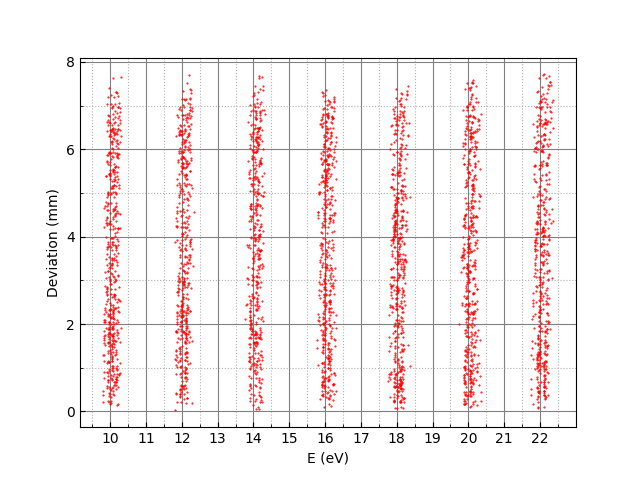

In [40]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from funcs import *

fig, ax = plt.subplots()
x_start = 9
x_end = 22
x_interval = 1
y_start = 0
y_end = 10
y_interval = 2
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"E (eV)", r"Deviation (mm)", set=False)

x = np.arange(x_start, x_end, 1)
energies = [14.40, 13.08, 11.27, 9.95, 8.16, 6.84]
e, r = [], []
with open("./data/dist_coords_ret_339.txt", "r") as f_c:
    with open("./data/dist_energies_ret_339.txt", "r") as f_e:
        while True:
            s_c = f_c.readline()
            s_e = f_e.readline()
            if s_c == "" or s_e == "":
                break
            num_c = s_c.split()
            num_e = s_e.split()
            if round(float(num_c[2])) > 0: #== 1016 516
                r.append(np.sqrt(float(num_c[1]) ** 2 + float(num_c[3]) ** 2))
                e.append(float(num_e[1]))

ax.scatter(e, r, s=0.25, c="red", zorder=3)
# ax.vlines(energies, 0, 5, lw=1, color='b')

## 23.76eV single peak <a class="anchor" id="section-8"></a>

499.39960213774435
234.4153401230533


,"Energy, eV","Theory, ns","t, ns","dt, ns","dt/t, %","dE/E, %","dE, eV","Sigma, ns"
0,10,600.893855,234.696,4.217133,1.796849,3.593698,0.179685,3.296585


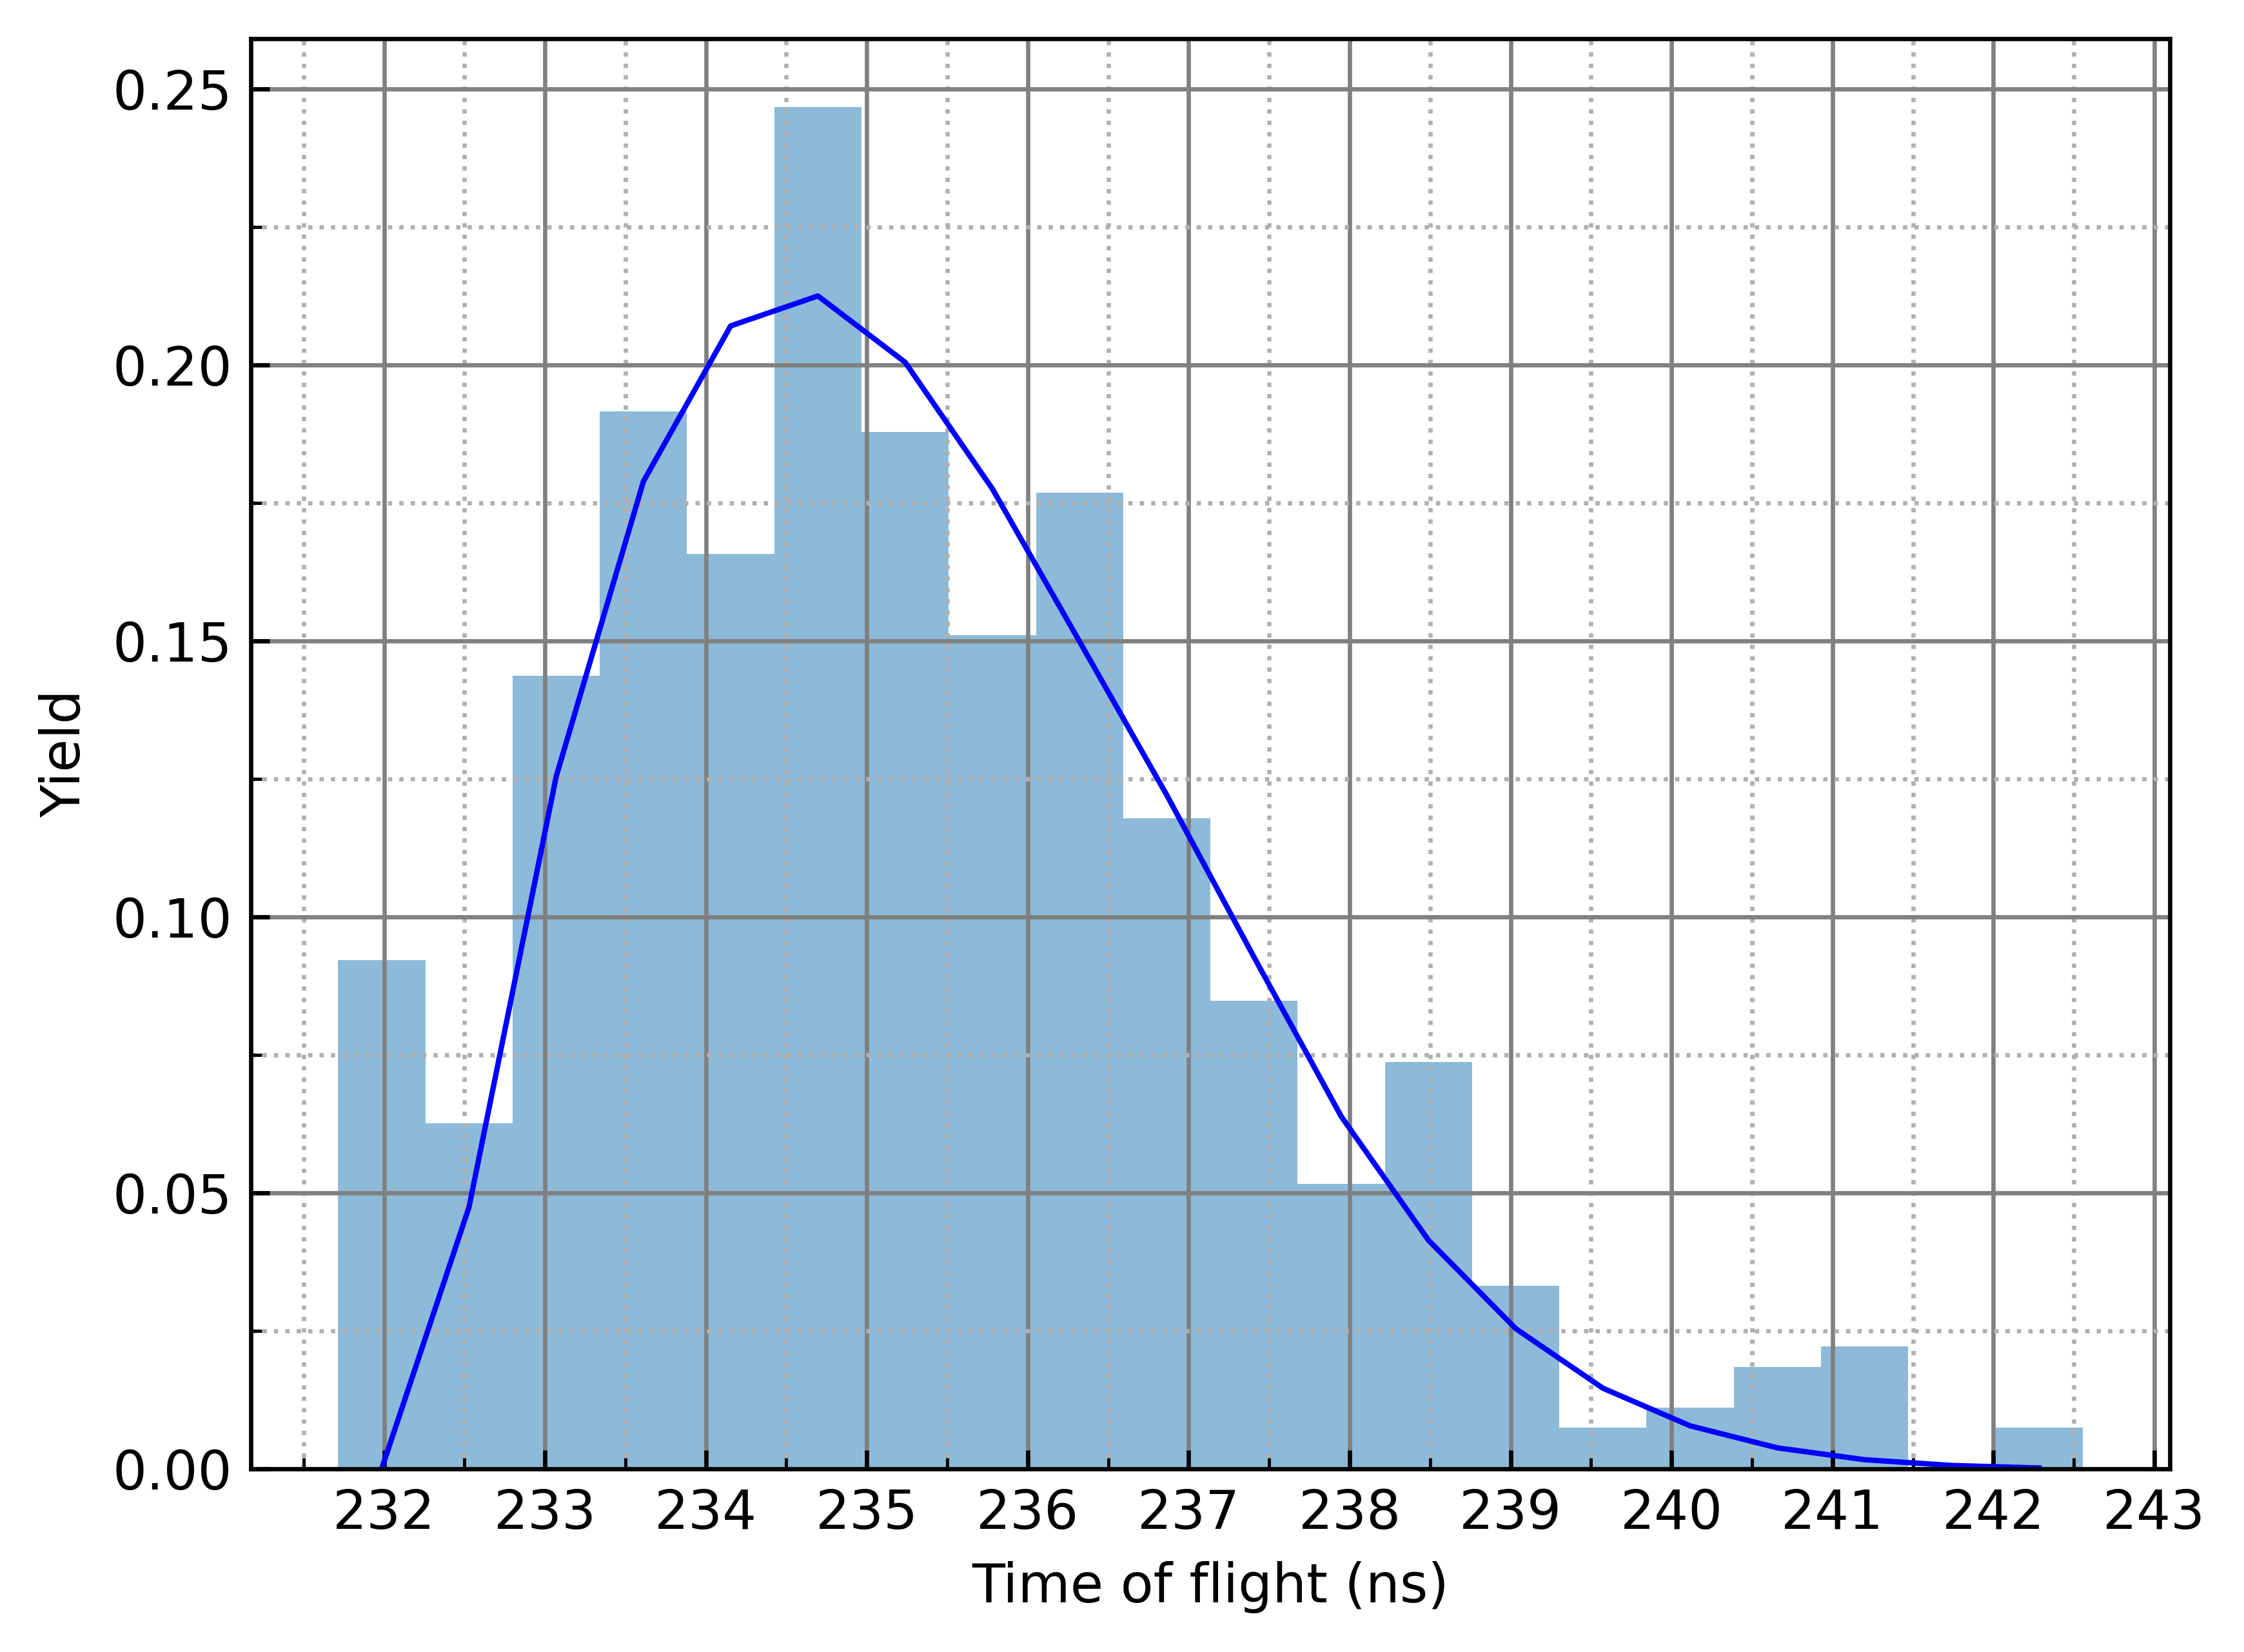

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
from scipy.optimize import curve_fit
from scipy.signal import peak_widths, find_peaks
from funcs import *

fig, ax = plt.subplots(dpi=600)
x_start = 231
x_end = 243
x_interval = 1
y_start = 0
y_end = 0.1
y_interval = 0.05
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
    r"Time of flight (ns)", r"Yield", set=False)

data, _ = read_file('./data/1k_ret_new.txt', delimeter=None)
y, x, _ = hist(data, 20, alpha=0.5, density=True)
x = (x[1:] + x[:-1]) / 2

times, sigmas, widths = [], [], []
energies = [75-65]
straight_times = time_of_flight(np.array(energies))

def energy_from_time(t, ret_pos, v_ret):
    return 6.242e18*ELECTRON_MASS*0.5*(TUBE_LENGTH*1e6/t)**2

def time_of_flight(E: float, L):  # ns
    return L / velocity(E) * 1e9

bins = [(230, 244)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax, (234, 1, 1, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

d = {
    "Energy, eV": energies[:len(times)],
    "Theory, ns": straight_times[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
print(time_of_flight(75, 125)+time_of_flight(10, 1016-125))
print(time_of_flight(75-0.15, 125)+time_of_flight(10-0.15, 516-125))
df